### 3. Data Modelling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
Train_data=pd.read_csv('Preprocessed_Train_data9.csv')
Test_data=pd.read_csv('Preprocessed_Test_data9.csv')

In [3]:
Train_data.head(2)

,Unnamed: 0,PerProvider_InscClaimAmtReimbursed_count,PerProvider_DeductibleAmtPaid_count,PerProvider_IPAnnualReimbursementAmt_count,PerProvider_IPAnnualDeductibleAmt_count,PerProvider_OPAnnualReimbursementAmt_count,PerProvider_OPAnnualDeductibleAmt_count,PerProvider_age_count,PerProvider_Hospitalized_period_count,PerProvider_claim_period_count,...,age,died,PotentialFraud,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5,cluster
0,0,107,107,107,107,107,107,107,107,107,...,67.0,0,1,1,0,1,0,0,0,9
1,1,107,107,107,107,107,107,107,107,107,...,78.0,0,1,1,0,1,0,0,0,3


In [4]:
Test_data.head(2)

,Unnamed: 0,PerProvider_InscClaimAmtReimbursed_count,PerProvider_DeductibleAmtPaid_count,PerProvider_IPAnnualReimbursementAmt_count,PerProvider_IPAnnualDeductibleAmt_count,PerProvider_OPAnnualReimbursementAmt_count,PerProvider_OPAnnualDeductibleAmt_count,PerProvider_age_count,PerProvider_Hospitalized_period_count,PerProvider_claim_period_count,...,age,died,PotentialFraud,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5,cluster
0,0,26,26,26,26,26,26,26,26,26,...,72.0,0,0,0,1,1,0,0,0,14
1,1,26,26,26,26,26,26,26,26,26,...,83.0,0,0,0,1,1,0,0,0,14


In [21]:
# Seperate dependent and independent variables
x_train = Train_data.drop(axis=1,columns=['Unnamed: 0','Provider','PotentialFraud'])
y_train = Train_data['PotentialFraud']
x_test = Test_data.drop(axis=1,columns=['Unnamed: 0','Provider','PotentialFraud'])
y_test = Test_data['PotentialFraud']

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [28]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train = standard_scaler.transform(x_train)
x_test = standard_scaler.transform(x_test)

In [8]:
from collections import Counter
print('Train')
counter = Counter(y_train)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

print('Test')
counter = Counter(y_test)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Train
Fraud Percentage = 36.07% and Non-Fraud Percentage = 63.93%
Test
Fraud Percentage = 44.63% and Non-Fraud Percentage = 55.37%


1. we have 36.07% of fraud data and 63.93% of non-fraud data in Train data
2. we have 44.63% of fraud data and 55.37% of non-fraud data in Test data

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import seaborn as sns

C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [10]:
def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [11]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm1 = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm1, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    plt.grid()
    plt.show()
    print("Number of misclassified points ",(len(y_test_pred)-np.trace(cm1))/len(y_test_pred)*100)
    
    return train_prediction, test_prediction

In [12]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
#     print(len(test_prediction))
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

#### Logistic Regression Hyper parameter tuning

In [52]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
grid={"C":[0.0001,0.001,0.01,0.1,1,10]}
logreg = LogisticRegression(class_weight='balanced')
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1)
logreg_cv.fit(x_train, y_train)

print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.001}
roc_auc_score : 0.9009327848079437


#### Logistic Regression

Train AUC =  0.8631283407565332
Test AUC =  0.9220489841887227


C:\Users\HP\AppData\Local\Temp\ipykernel_13740\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


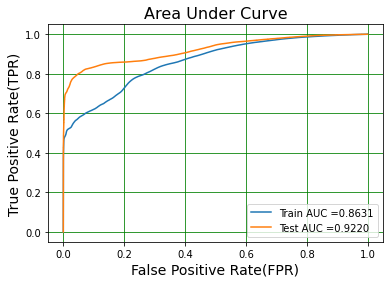

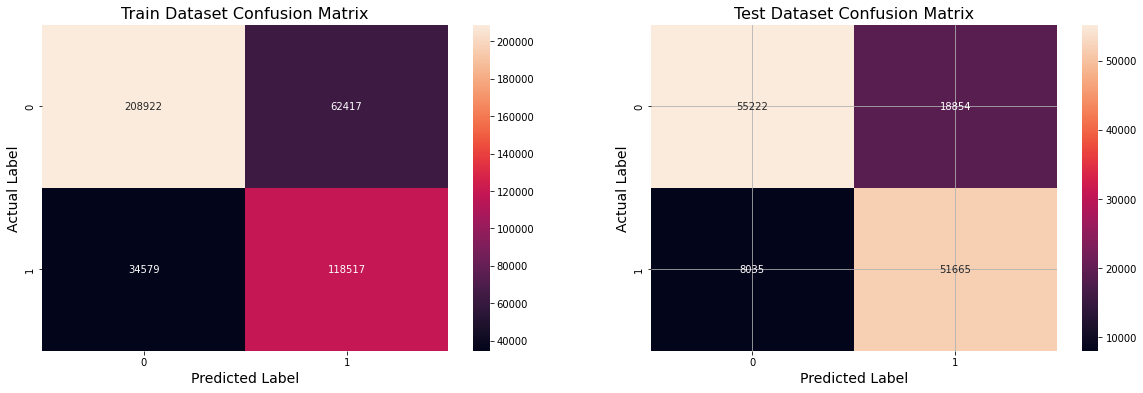

Number of misclassified points  20.10001794043775
Best Threshold = 0.2698
Model AUC is : 0.9220
Model F1 Score is : 0.7935


In [53]:
log_reg = LogisticRegression(C=0.001, penalty='l2')
log_reg.fit(x_train, y_train)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [34]:
with open('log_reg.pkl', 'rb') as f:
    log_clf = pickle.load(f)
from sklearn.metrics import precision_score, recall_score
y_pred=log_clf.predict(x_test)
precision= precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print('precision score is =',precision)
print('recall score is=', recall)

precision score is = 0.9226497040510416
recall score is= 0.8042043551088777


In [54]:
import pickle
pickle.dump(log_reg, open("log_reg.pkl", "wb"))

#### Observations
1. we got best hyper parameter as 0.001
2. AUC is 0.92
3. F1 score is 0.7935
4. our model has 20% of misclassified points on test dataset

#### Decision Tree Hyper parameter Tuning

In [55]:
Decisiontree = DecisionTreeClassifier()

parameters = {'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250]}

Decisiontree_cv = GridSearchCV(Decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
Decisiontree_cv.fit(x_train, y_train)

print("best parameters = ",Decisiontree_cv.best_params_)
print("roc_auc_score :",Decisiontree_cv.best_score_)

best parameters =  {'max_depth': 5, 'min_samples_split': 5}
roc_auc_score : 0.8831486805532476


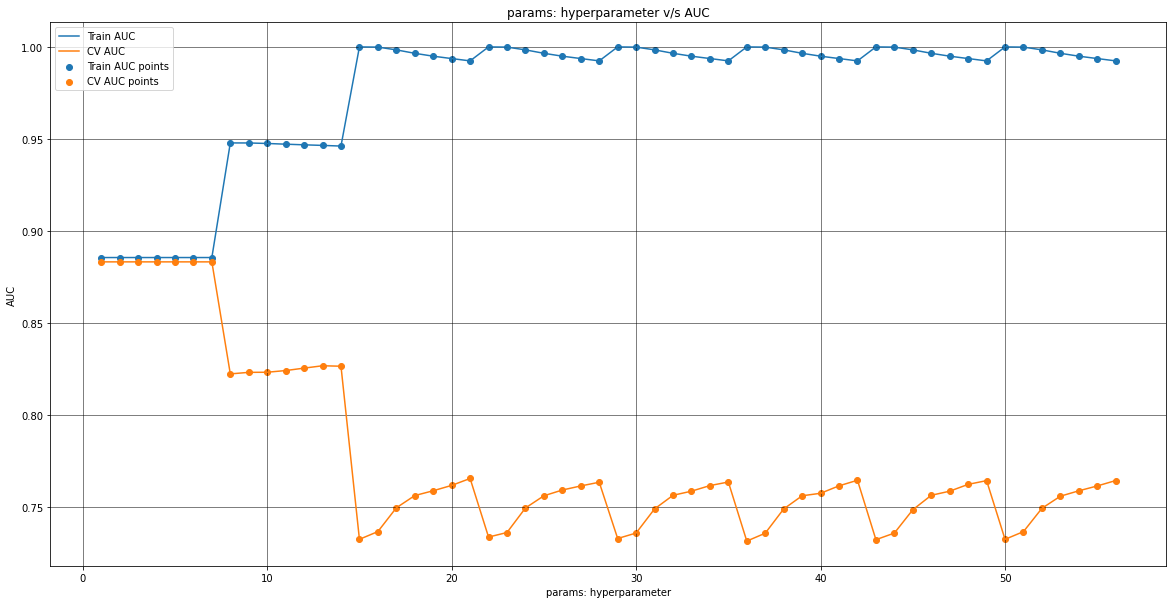

In [56]:
train_auc= Decisiontree_cv.cv_results_['mean_train_score']
train_auc_std= Decisiontree_cv.cv_results_['std_train_score']
cv_auc = Decisiontree_cv.cv_results_['mean_test_score']
cv_auc_std= Decisiontree_cv.cv_results_['std_test_score']

params=[i for i in range(1,57)]

#plotting gragh between log alphas and Train and CV AUC Curve
plt.figure(figsize=(20,10))
plt.plot(params, train_auc, label='Train AUC')

plt.plot(params, cv_auc, label='CV AUC')

plt.scatter(params, train_auc, label='Train AUC points')
plt.scatter(params, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("params: hyperparameter")
plt.ylabel("AUC")
plt.title("params: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#### Decision Tree

Train AUC =  0.8812367800061022
Test AUC =  0.9083832379403363


C:\Users\HP\AppData\Local\Temp\ipykernel_13740\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


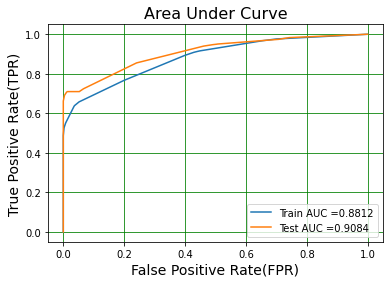

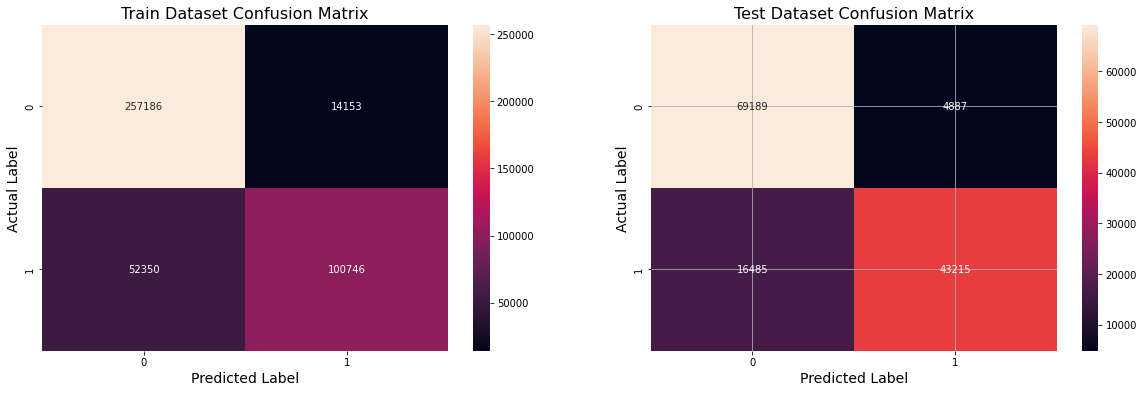

Number of misclassified points  15.975959813419447
Best Threshold = 0.3194
Model AUC is : 0.9084
Model F1 Score is : 0.8017


In [57]:
Decision_tree = DecisionTreeClassifier(max_depth = 5, min_samples_split = 5)
Decision_tree.fit(x_train, y_train)

# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(Decision_tree, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [33]:
with open('DT.pkl', 'rb') as f:
    dt_clf = pickle.load(f)
from sklearn.metrics import precision_score, recall_score
y_pred=dt_clf.predict(x_test)
precision= precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print('precision score is =',precision)
print('recall score is=', recall)

precision score is = 0.9133958127337604
recall score is= 0.7117755443886097


In [58]:
import pickle
pickle.dump(Decision_tree, open("DT.pkl", "wb"))

#### Observations
1. Decision has performed very well.
2. we got AUC as 0.90
3. F1 score is 0.80 and is very close to 1.
4. we have 16% of misclassified points.

#### SVM Hyperparameter Tuning

In [59]:
grid={"C":[0.5, 1.0]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1)
svm_cv.fit(x_train, y_train)

print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5}
roc_auc_score : 0.8960938415672249


C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### SVM

C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Train AUC =  0.8609750246866152
Test AUC =  0.9204275040356489


C:\Users\HP\AppData\Local\Temp\ipykernel_13740\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


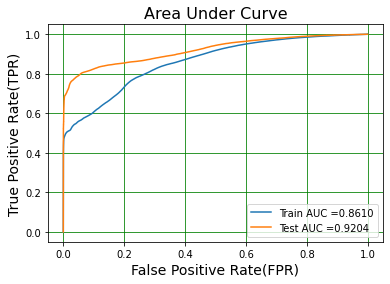

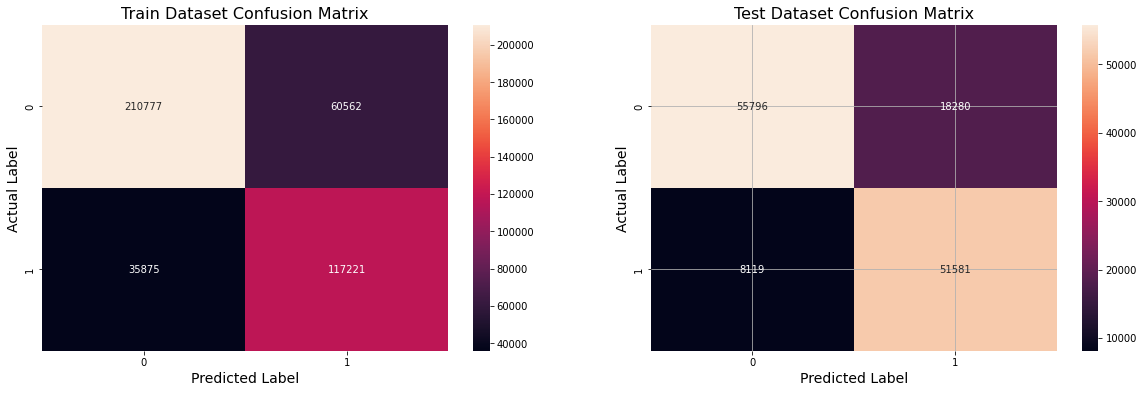

Number of misclassified points  19.733734003109678
Best Threshold = 0.3200
Model AUC is : 0.9204
Model F1 Score is : 0.7962


In [60]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5)
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_train, y_train)

# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [32]:
with open('svc.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
from sklearn.metrics import precision_score, recall_score
y_pred=svc_clf.predict(x_test)
precision= precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print('precision score is =',precision)
print('recall score is=', recall)

precision score is = 0.8613413190333589
recall score is= 0.828676716917923


In [61]:
import pickle
pickle.dump(clb_clf_svc, open("svc.pkl", "wb"))

#### Observations
1. SVM also performed well
2. AUC is 0.92
3. F1 score is 0.79
4. 20% of misclassified points

#### Random Forest Hyper parameter Tuning

In [62]:
parameters={'n_estimators':[200,500,1000,2000],
            'min_samples_leaf': [10, 15],
            'max_depth': [40, 60]}
rf_clf=RandomForestClassifier()
rf_clf_cv = GridSearchCV(rf_clf, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
rf_clf_cv.fit(x_train, y_train)

print("best parameters = ",rf_clf_cv.best_params_)
print("roc_auc_score :",rf_clf_cv.best_score_)

best parameters =  {'max_depth': 40, 'min_samples_leaf': 15, 'n_estimators': 2000}
roc_auc_score : 0.8737568360929713


#### Random Forest Model

Train AUC =  0.9939713609408838
Test AUC =  0.9039626295344463


C:\Users\HP\AppData\Local\Temp/ipykernel_4584/373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


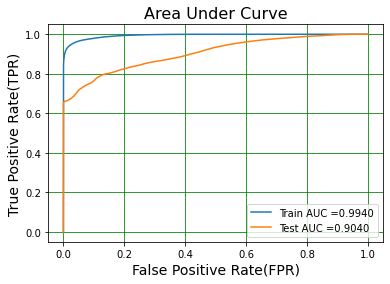

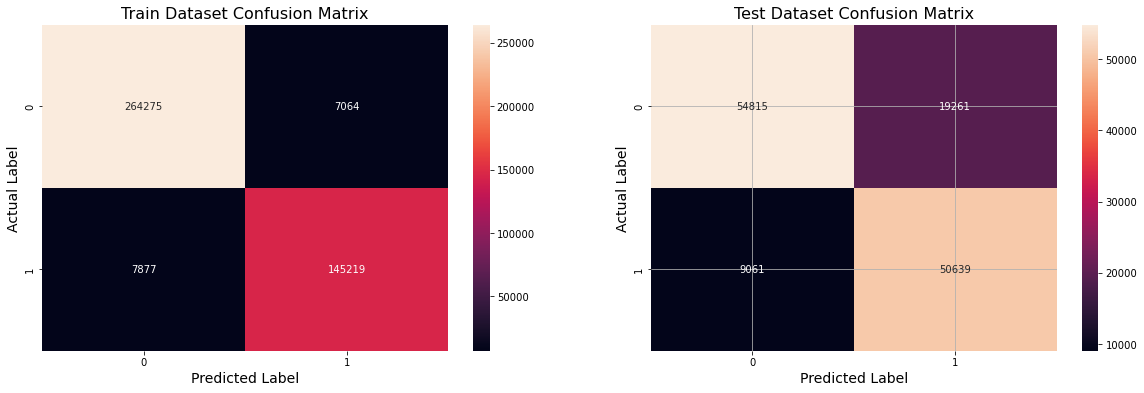

Number of misclassified points  21.17121157756249
Best Threshold = 0.3316
Model AUC is : 0.9040
Model F1 Score is : 0.7815


In [11]:
rf_clf=RandomForestClassifier(n_estimators=2000,max_depth=40, min_samples_leaf=15,random_state=42,n_jobs=-1)
rf_clf.fit(x_train,y_train)

# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(rf_clf, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [31]:
with open('RF.pkl', 'rb') as f:
    rf_clf = pickle.load(f)
from sklearn.metrics import precision_score, recall_score
y_pred=rf_clf.predict(x_test)
precision= precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print('precision score is =',precision)
print('recall score is=', recall)

precision score is = 0.8084533131262103
recall score is= 0.8041876046901173


#### Feature Importance

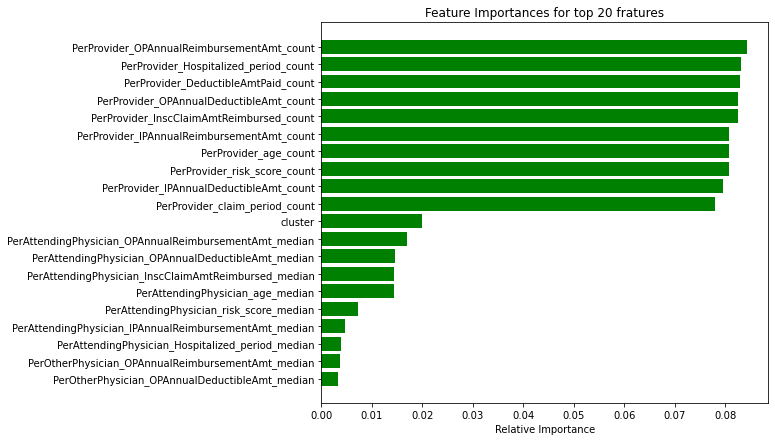

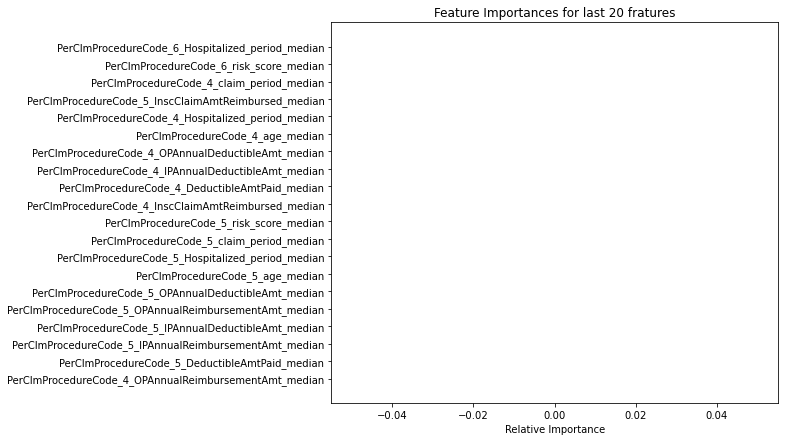

In [14]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot top 20 features
features = x_train.columns
importance_of_feature = rf_clf.feature_importances_
imp_feature_indx = np.argsort(rf_clf.feature_importances_)#[::-1]
# take_top_20 fratures
top_20_indices = imp_feature_indx[-20:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()
last_20_indices = imp_feature_indx[:20]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for last 20 fratures')
plt.barh(range(len(last_20_indices)), importance_of_feature[last_20_indices], color='r', align='center')
plt.yticks(range(len(last_20_indices)), [features[i] for i in last_20_indices])
plt.xlabel('Relative Importance')
plt.show()

In [16]:
import pickle
pickle.dump(rf_clf, open("RF.pkl", "wb"))

#### Observations
1. Random forest model is the best model
2. got AUC as 0.90
3. F1 score is 0.75
4. 21% of misclassified points which is very less

Train AUC =  0.9935671888426012
Test AUC =  0.8709969591418765


C:\Users\HP\AppData\Local\Temp\ipykernel_13892\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


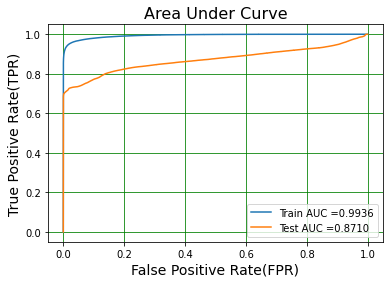

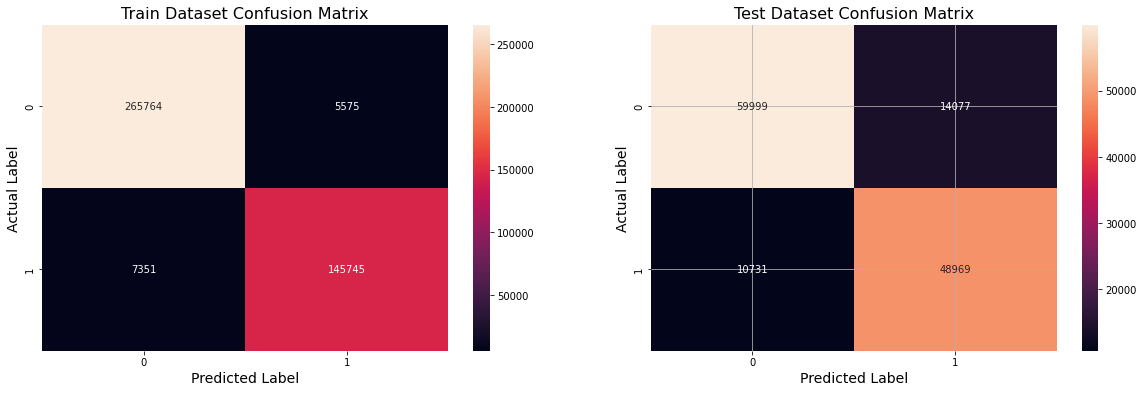

Number of misclassified points  18.544432484152612
Best Threshold = 0.3290
Model AUC is : 0.8710
Model F1 Score is : 0.7979


In [17]:
xgb_clf=XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_clf.fit(x_train, y_train)

test_auc, test_f1_score, best_t = validate_model(xgb_clf, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [19]:
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb_clf_cv = GridSearchCV(xgb_clf, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_clf_cv.fit(x_train, y_train)

print("best parameters = ",xgb_clf_cv.best_params_)
print("roc_auc_score :",xgb_clf_cv.best_score_)

best parameters =  {'max_depth': 3, 'min_child_weight': 1}
roc_auc_score : 0.8462843842874477


[10:30:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train AUC =  0.9780436980130128
Test AUC =  0.8816139524593465


C:\Users\HP\AppData\Local\Temp\ipykernel_13892\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


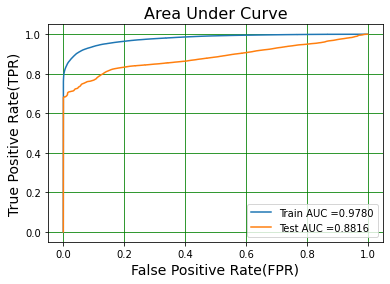

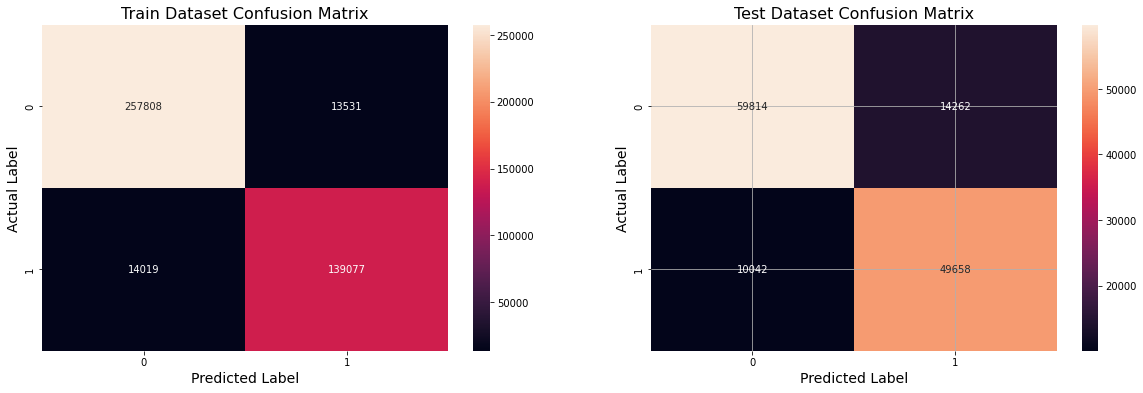

Number of misclassified points  18.16768329147231
Best Threshold = 0.3181
Model AUC is : 0.8816
Model F1 Score is : 0.8034


In [20]:
xgb_clf=XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_clf.fit(x_train, y_train)

test_auc, test_f1_score, best_t = validate_model(xgb_clf, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train AUC =  0.977699015094678
Test AUC =  0.8812771619947932


C:\Users\HP\AppData\Local\Temp\ipykernel_400\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


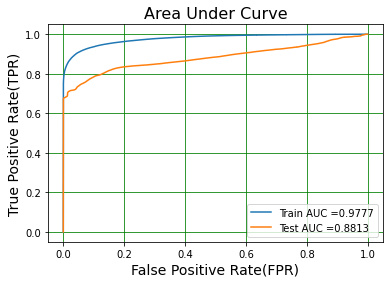

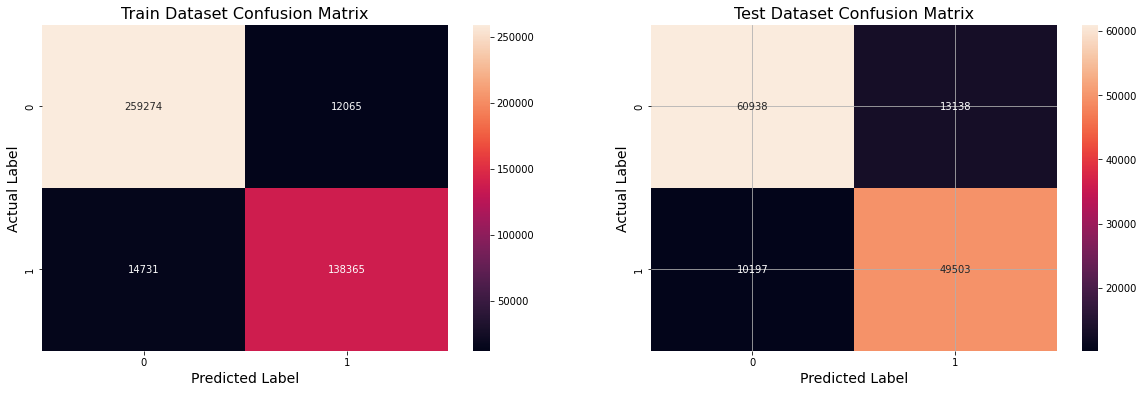

Number of misclassified points  17.443338117450065
Best Threshold = 0.3327
Model AUC is : 0.8813
Model F1 Score is : 0.8093


In [15]:
xgb_clf=XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.6,
 colsample_bytree=0.6,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_clf.fit(x_train, y_train)

test_auc, test_f1_score, best_t = validate_model(xgb_clf, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [29]:
from sklearn.metrics import precision_score, recall_score
y_pred=xgb_clf.predict(x_test)
precision= precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print('precision score is =',precision)
print('recall score is=', recall)

precision score is = 0.8340084506058596
recall score is= 0.8001172529313233


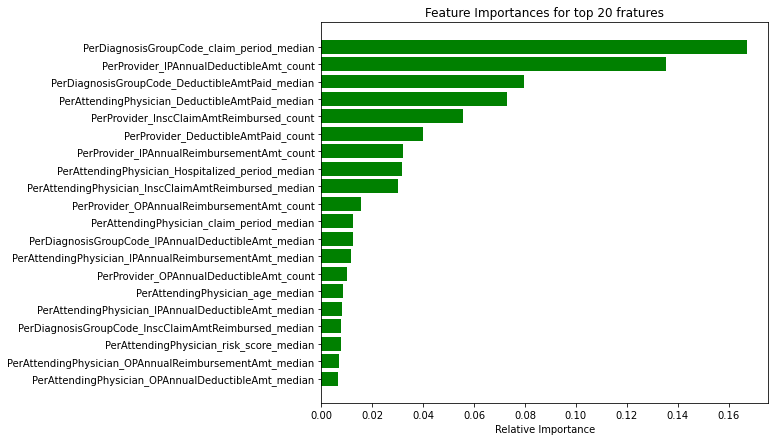

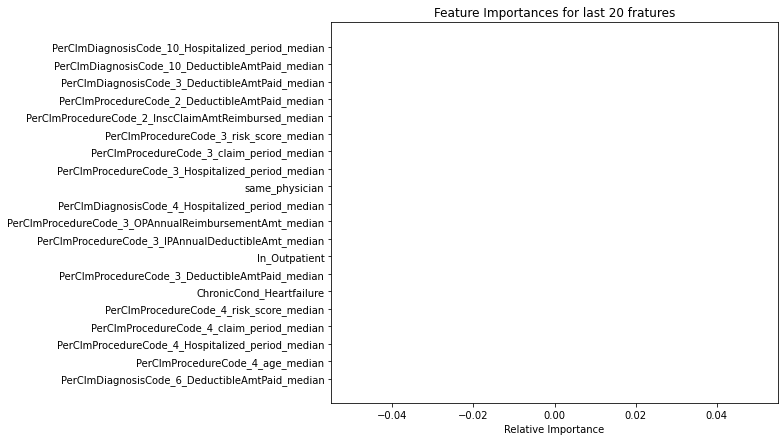

In [22]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot top 20 features
features = x_train.columns
importance_of_feature = xgb_clf.feature_importances_
imp_feature_indx = np.argsort(xgb_clf.feature_importances_)#[::-1]
# take_top_20 fratures
top_20_indices = imp_feature_indx[-20:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()
last_20_indices = imp_feature_indx[:20]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for last 20 fratures')
plt.barh(range(len(last_20_indices)), importance_of_feature[last_20_indices], color='r', align='center')
plt.yticks(range(len(last_20_indices)), [features[i] for i in last_20_indices])
plt.xlabel('Relative Importance')
plt.show()

In [24]:
import pickle
pickle.dump(xgb_clf, open("XGB.pkl", "wb"))

#### Data Modelling without averaging features

In [8]:
Noavg_Train_data= pd.read_csv('Preprocessed_Train_data9_woavg.csv')
Noavg_Test_data = pd.read_csv('Preprocessed_Test_data9_woavg.csv')

In [9]:
Noavg_Train_data.columns

Index(['Unnamed: 0', 'Provider', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'claim_period', 'Hospitalized_period', 'ExtraClaimDays',
       'same_physician', 'In_Outpatient', 'RenalDiseaseIndicator',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'risk_score',
       'age', 'died', 'PotentialFraud', 'Gender_1', 'Gender_2', 'Race_1',
       'Race_2', 'Race_3', 'Race_5', 'cluster'],
      dtype='object')

In [10]:
Noavg_Train_data.head(2)

,Unnamed: 0,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,claim_period,Hospitalized_period,ExtraClaimDays,same_physician,In_Outpatient,RenalDiseaseIndicator,...,age,died,PotentialFraud,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5,cluster
0,0,PRV55912,26000,1068.0,7,7.0,0.0,0,1,0,...,67.0,0,1,1,0,1,0,0,0,0
1,1,PRV55912,19000,1068.0,13,13.0,0.0,0,1,0,...,96.0,1,1,0,1,1,0,0,0,24


In [11]:
Noavg_Test_data.head(2)

,Unnamed: 0,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,claim_period,Hospitalized_period,ExtraClaimDays,same_physician,In_Outpatient,RenalDiseaseIndicator,...,age,died,PotentialFraud,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5,cluster
0,0,PRV56614,10000,1068.0,18,18.0,0.0,0,1,1,...,72.0,0,0,0,1,1,0,0,0,13
1,1,PRV56614,2000,1068.0,3,3.0,0.0,0,1,1,...,83.0,0,0,0,1,1,0,0,0,13


In [39]:
# Seperate dependent and independent variables
x_train = Noavg_Train_data.drop(axis=1,columns=['Unnamed: 0','Provider','PotentialFraud'])
y_train = Noavg_Train_data['PotentialFraud']
x_test = Noavg_Test_data.drop(axis=1,columns=['Unnamed: 0','Provider','PotentialFraud'])
y_test = Noavg_Test_data['PotentialFraud']

In [16]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train = standard_scaler.transform(x_train)
x_test = standard_scaler.transform(x_test)

In [17]:
from collections import Counter
print('Train')
counter = Counter(y_train)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

print('Test')
counter = Counter(y_test)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Train
Fraud Percentage = 56.48% and Non-Fraud Percentage = 43.52%
Test
Fraud Percentage = 44.63% and Non-Fraud Percentage = 55.37%


#### Logistic Regression Hyper parameter tuning

In [22]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
grid={"C":[0.0001,0.001,0.01,0.1,1,10]}
logreg = LogisticRegression(class_weight='balanced')
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_train, y_train)

print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.0001}
roc_auc_score : 0.5128822980344483


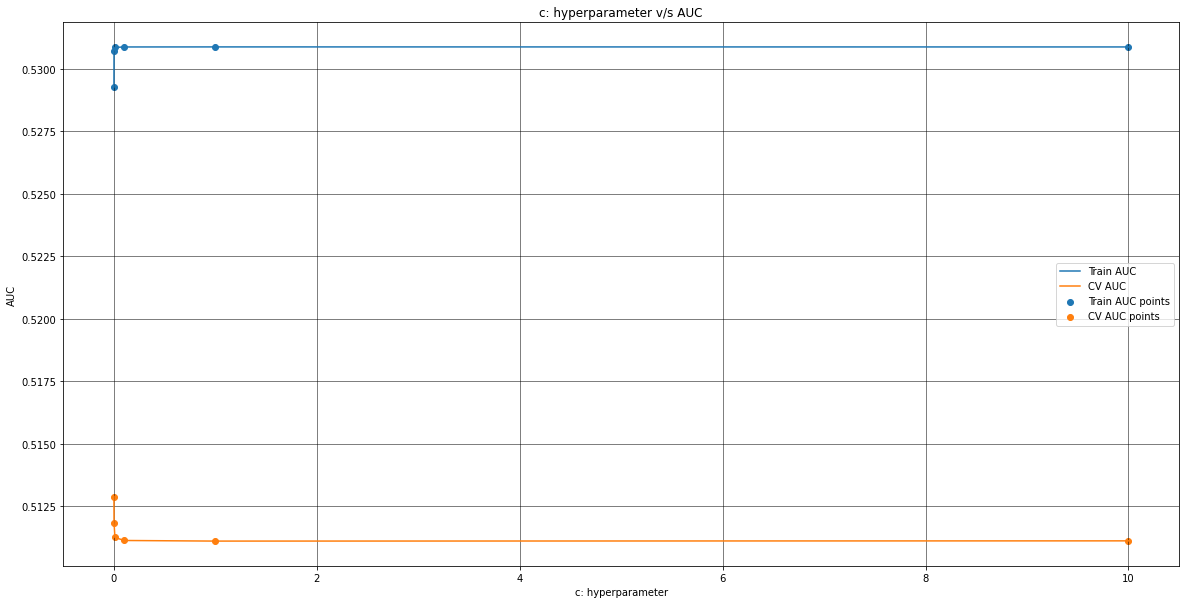

In [23]:
train_auc= logreg_cv.cv_results_['mean_train_score']
train_auc_std= logreg_cv.cv_results_['std_train_score']
cv_auc = logreg_cv.cv_results_['mean_test_score']
cv_auc_std= logreg_cv.cv_results_['std_test_score']

c=[0.0001,0.001,0.01,0.1,1,10]
#plotting gragh between log alphas and Train and CV AUC Curve
plt.figure(figsize=(20,10))
plt.plot(c, train_auc, label='Train AUC')

plt.plot(c, cv_auc, label='CV AUC')

plt.scatter(c, train_auc, label='Train AUC points')
plt.scatter(c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("c: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#### Logistic Regression

Train AUC =  0.528196596538986
Test AUC =  0.5076918698103798


C:\Users\HP\AppData\Local\Temp\ipykernel_13740\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


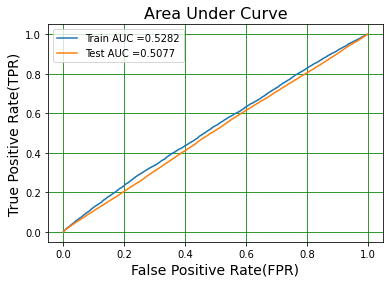

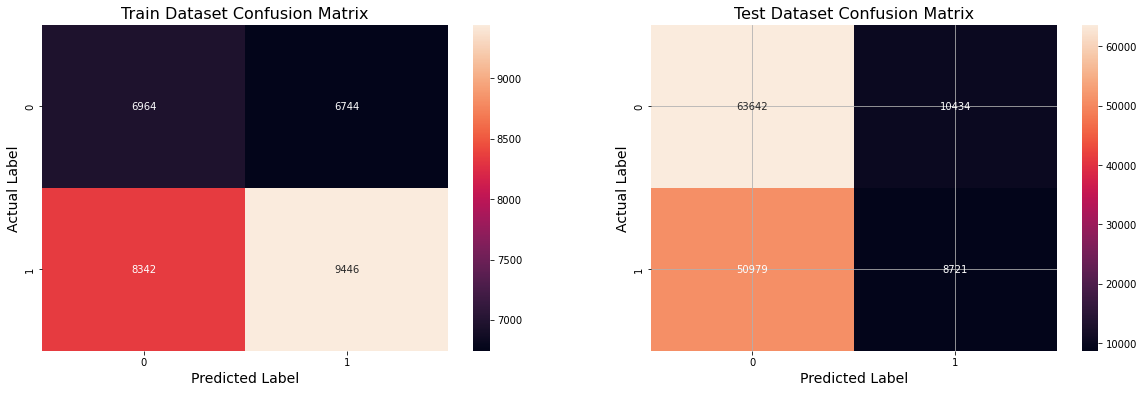

Number of misclassified points  45.907337639038396
Best Threshold = 0.5618
Model AUC is : 0.5077
Model F1 Score is : 0.2212


In [25]:
log_reg = LogisticRegression(C=0.0001,class_weight='Balanced')
log_reg.fit(x_train, y_train)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [33]:
import pickle
pickle.dump(log_reg, open("log_reg_woavg.pkl", "wb"))

#### Observations
1. we got best hyper parameter as 0.0001
2. AUC is 0.50
3. F1 score is 0.22
4. our model has 46% of misclassified points on test dataset
5. without averaging features trhe model has not performed well

#### Decision Tree Hyperparameter Tuning

In [27]:
Decisiontree = DecisionTreeClassifier() 
parameters = {'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

Decisiontree_cv = GridSearchCV(Decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
Decisiontree_cv.fit(x_train, y_train)

print("best parameters = ",Decisiontree_cv.best_params_)
print("roc_auc_score :",Decisiontree_cv.best_score_)

best parameters =  {'max_depth': 10, 'min_samples_split': 250}
roc_auc_score : 0.5127556583915007


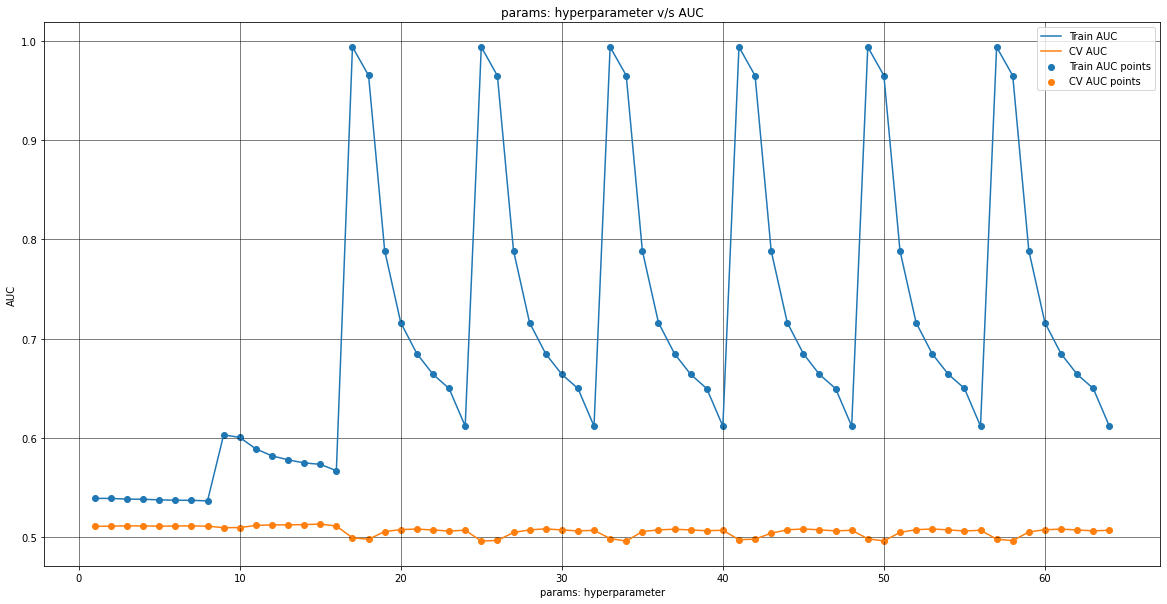

In [28]:
train_auc= Decisiontree_cv.cv_results_['mean_train_score']
train_auc_std= Decisiontree_cv.cv_results_['std_train_score']
cv_auc = Decisiontree_cv.cv_results_['mean_test_score']
cv_auc_std= Decisiontree_cv.cv_results_['std_test_score']

params=[i for i in range(1,65)]

#plotting gragh between log alphas and Train and CV AUC Curve
plt.figure(figsize=(20,10))
plt.plot(params, train_auc, label='Train AUC')

plt.plot(params, cv_auc, label='CV AUC')

plt.scatter(params, train_auc, label='Train AUC points')
plt.scatter(params, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("params: hyperparameter")
plt.ylabel("AUC")
plt.title("params: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#### Decision Tree

Train AUC =  0.5686323853899269
Test AUC =  0.514157066087136


C:\Users\HP\AppData\Local\Temp\ipykernel_13740\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


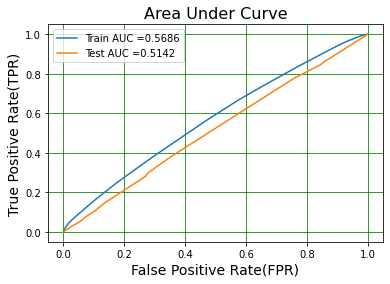

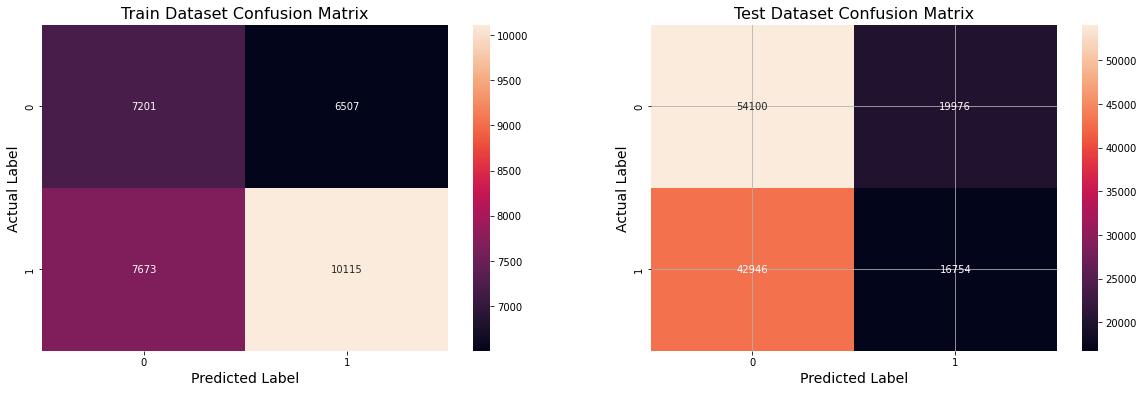

Number of misclassified points  47.03534266236096
Best Threshold = 0.5758
Model AUC is : 0.5142
Model F1 Score is : 0.3475


In [29]:
Decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
Decision_tree.fit(x_train, y_train)

# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(Decision_tree, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [34]:
import pickle
pickle.dump(Decision_tree, open("DT_woavg.pkl", "wb"))

#### Observations
1. Decision tree performed well with averaging features
2. AUC is 0.51
3. F1 score is 0.34
4. our model has 47% of misclassified points on test dataset

#### SVM Hyperparameter Tuning

In [30]:
grid={"C":[0.5, 1.0],}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_train, y_train)

print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5}
roc_auc_score : 0.5108570182913857


C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### SVM

C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\anaconda3\envs\tf-gpu1\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\AppData\Local\Temp\ipykernel_13740\373669981.py:16: MatplotlibDeprecationWarni

Train AUC =  0.5286677168944169
Test AUC =  0.5040266741758181


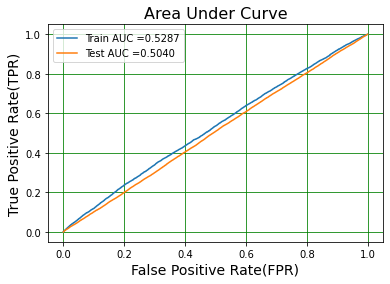

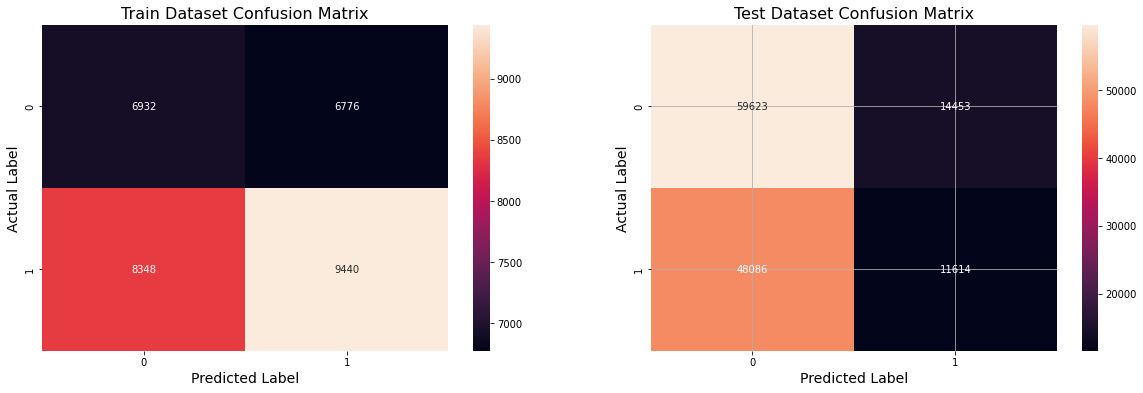

Number of misclassified points  46.74904317665351
Best Threshold = 0.5628
Model AUC is : 0.5040
Model F1 Score is : 0.2708


In [31]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_train, y_train)

# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [35]:
import pickle
pickle.dump(clb_clf_svc, open("svc_woavg.pkl", "wb"))

#### Observations
1. we got best hyper parameter as 0.5
2. AUC is 0.50
3. F1 score is 0.27
4. our model has 47% of misclassified points on test dataset

#### Random Forest Hyperv parameter Tuning

In [32]:
parameters={'n_estimators':[200,500,1000,2000],
            'min_samples_leaf': [10, 15],
            'max_depth': [40, 60, 80]}
rf_clf=RandomForestClassifier()
rf_clf_cv = GridSearchCV(rf_clf, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
rf_clf_cv.fit(x_train, y_train)

print("best parameters = ",rf_clf_cv.best_params_)
print("roc_auc_score :",rf_clf_cv.best_score_)

best parameters =  {'max_depth': 40, 'min_samples_leaf': 15, 'n_estimators': 200}
roc_auc_score : 0.5177223402171249


#### Random Forest Model

Train AUC =  0.8357760982066185
Test AUC =  0.5030757963232654


C:\Users\HP\AppData\Local\Temp\ipykernel_13740\373669981.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='g', linestyle='-')


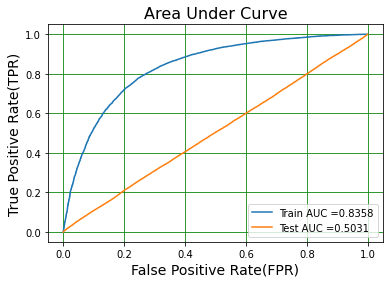

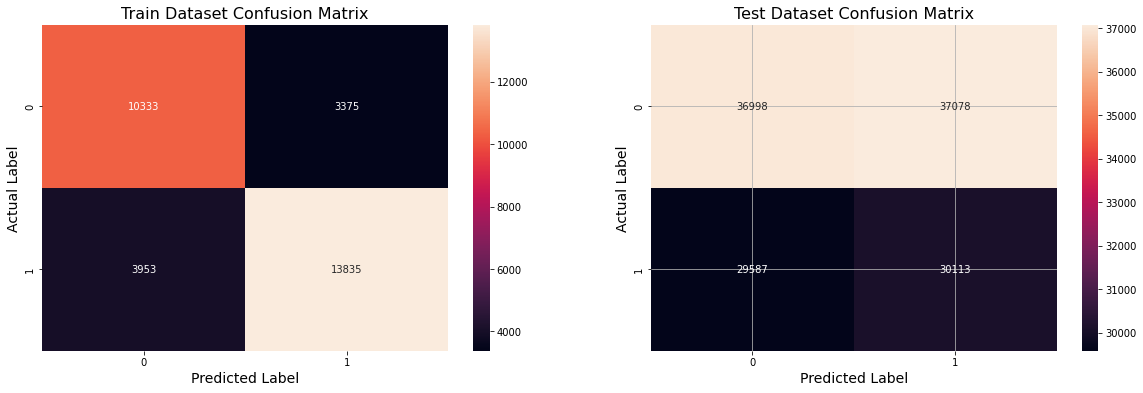

Number of misclassified points  49.833303432603756
Best Threshold = 0.5571
Model AUC is : 0.5031
Model F1 Score is : 0.4746


In [36]:
rf_clf=RandomForestClassifier(n_estimators=200,max_depth=40,min_samples_leaf=15,random_state=42,n_jobs=-1)
rf_clf.fit(x_tr,y_tr)

# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(rf_clf, x_train, x_test, y_train, y_test)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [37]:
import pickle
pickle.dump(rf_clf, open("rf_clf_woavg.pkl", "wb"))

#### Feature Importances

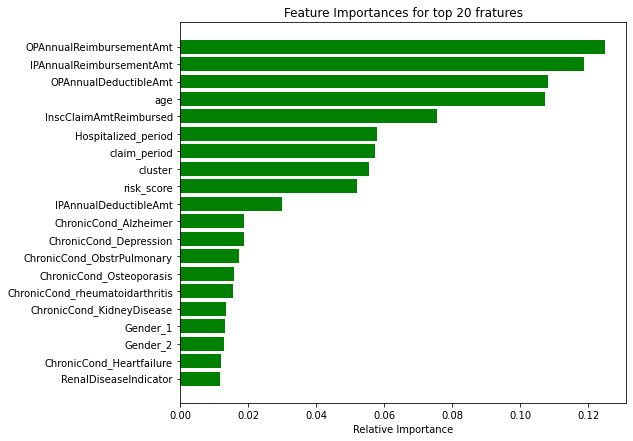

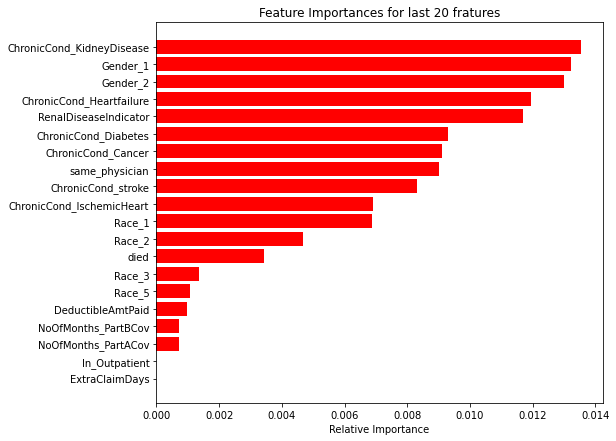

In [40]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot top 20 features
features = x_train.columns
importance_of_feature = rf_clf.feature_importances_
imp_feature_indx = np.argsort(rf_clf.feature_importances_)#[::-1]
# take_top_20 fratures
top_20_indices = imp_feature_indx[-20:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()
last_20_indices = imp_feature_indx[:20]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for last 20 fratures')
plt.barh(range(len(last_20_indices)), importance_of_feature[last_20_indices], color='r', align='center')
plt.yticks(range(len(last_20_indices)), [features[i] for i in last_20_indices])
plt.xlabel('Relative Importance')
plt.show()

#### Observations
1. Random forest model didn't performed well. looks like slightly overfitted.
2. AUC is 0.50
3. F1 score 0.47
4. 50% of points are misclassified by our model
5. from feature importances, we observe that the features cluster, risk score, age, hospitalized period, claim period which we calculated are most important features while modelling.

#### Model Analysis

Models performance with averaging features

In [37]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Model', 'Best HyperParameter',  'Train AUC','Test AUC','F1 Score','Precision','Recall','% Misclassified Points']

table.add_row(['Logistic Regression',0.001,0.86,0.92,0.793,0.92,0.80,20])
table.add_row(['Decision Tree',5,0.88,0.90,0.80,0.90,0.71,16])
table.add_row(['SVM',0.5,0.86,0.92,0.79,0.86,0.82,19])
table.add_row(['Random Forest',2000,0.99,0.90,0.78,0.80,0.80,21])
table.add_row(['XGBoost',1000,0.97,0.88,0.80,0.83,0.80,17])

print(table)


+---------------------+---------------------+-----------+----------+----------+-----------+--------+------------------------+
|        Model        | Best HyperParameter | Train AUC | Test AUC | F1 Score | Precision | Recall | % Misclassified Points |
+---------------------+---------------------+-----------+----------+----------+-----------+--------+------------------------+
| Logistic Regression |        0.001        |    0.86   |   0.92   |  0.793   |    0.92   |  0.8   |           20           |
|    Decision Tree    |          5          |    0.88   |   0.9    |   0.8    |    0.9    |  0.71  |           16           |
|         SVM         |         0.5         |    0.86   |   0.92   |   0.79   |    0.86   |  0.82  |           19           |
|    Random Forest    |         2000        |    0.99   |   0.9    |   0.78   |    0.8    |  0.8   |           21           |
|       XGBoost       |         1000        |    0.97   |   0.88   |   0.8    |    0.83   |  0.8   |           17     

Models performance without averaging features

In [38]:
table = PrettyTable()
table.field_names = ['Model', 'Best HyperParameter','Train AUC','Test AUC','F1 Score', 'Percentage of Misclassified Points']

table.add_row(['Logistic Regression',0.0001,0.52,0.50,0.22,45])
table.add_row(['Decision Tree',10,0.56,0.50,0.27,46])
table.add_row(['SVM',0.5,0.52,0.50,0.27,46])
table.add_row(['Random Forest',2000,0.83,0.50,0.47,49])

print(table)


+---------------------+---------------------+-----------+----------+----------+------------------------------------+
|        Model        | Best HyperParameter | Train AUC | Test AUC | F1 Score | Percentage of Misclassified Points |
+---------------------+---------------------+-----------+----------+----------+------------------------------------+
| Logistic Regression |        0.0001       |    0.52   |   0.5    |   0.22   |                 45                 |
|    Decision Tree    |          10         |    0.56   |   0.5    |   0.27   |                 46                 |
|         SVM         |         0.5         |    0.52   |   0.5    |   0.27   |                 46                 |
|    Random Forest    |         2000        |    0.83   |   0.5    |   0.47   |                 49                 |
+---------------------+---------------------+-----------+----------+----------+------------------------------------+


#### Conclusion

1. Models with averaging features performed well.
2. Clustering Features and Median features contribute most to the model.
3. By observing all parameters like f1 score,precision, recall - took logistic regression performed well.

#### Important points
1. Averaging features and cluster features are more important and helped in modelling.
2. Tree based algorithms are slightly overfitted because of averaging features.
3. so we choosed Logistic regression is out best model
4. we considered F1 score, precision and recall as the performance metrics.